In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
import pickle
from pathlib import Path
import codecs
import os

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV


# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from pprint import pprint
from wordcloud import WordCloud as wc

%matplotlib inline
pyLDAvis.enable_notebook()

#Setup data directory variable for global use
data_dir = Path.home() / "Desktop" / "bah-intermediate" / "CAPSTONE" / "data"
test_data = Path.home() / "Desktop" / "bah-intermediate" / "CAPSTONE" / "test_data"
viz_dir = Path.home() / "Desktop" / "bah-intermediate" / "CAPSTONE" / "visualizations"
model_dir = Path.home() / "Desktop" / "bah-intermediate" / "CAPSTONE" / "models"

In [2]:
def current_time():
    now = datetime.now()
    return now.strftime("%d%m%y%H%M%S")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def pipeline(texts, n_topics=10, random_state=42, max_df=1.0, min_df=1, ngram_range=(1,1), vec_type='cv', n_top_words=5):
    print('Parameters are:',
          '\nmax_df: ', max_df,
         '\nmin_df: ', min_df,
         '\nngram_range:', ngram_range,
         '\nvec_type: ', vec_type,
         '\nn_top_words: ', n_top_words,'\n')
    if vec_type == 'cv':
        print('Using CountVectorizer\n')
        vectorizer = CountVectorizer(max_df=max_df,
                                    min_df=min_df,
                                    ngram_range=ngram_range)

        dtm = vectorizer.fit_transform(texts)
    else:
        print('Using TfidfVectorizer\n')
        vectorizer = TfidfVectorizer(max_df=max_df,
                                    min_df=min_df,
                                    ngram_range=ngram_range)
    
        dtm = vectorizer.fit_transform(df.lemmed.values.tolist())
        
    fit_model = fit_lda_model(dtm, n_topics, random_state)
    
    log_likelihood = fit_model.score(dtm)
    perplexity = fit_model.perplexity(dtm)
    model_params = fit_model.get_params()
    
    # Log Likelyhood: Higher the better
    print("\nLog Likelihood (the higher the better): ", fit_model.score(dtm))
    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Perplexity (the lower the better): ", fit_model.perplexity(dtm))
    
    # See model parameters
    print('\nModel Parameters:')
    pprint(fit_model.get_params())
    print('\n')
        
    print_top_words(fit_model, vectorizer.get_feature_names(), n_top_words)
    print('\n')
    plot_top_words(fit_model, vectorizer, dtm, n_top_words, 
                   title="Top {} Words for LDA Model".format(n_top_words))
    print('\n')
    
    parameters_dict = {
        'max_df': max_df,
        'min_df': min_df,
        'ngram_range:': ngram_range,
        'vec_type: ': vec_type,
        'n_top_words: ': n_top_words,
        'vec_type': vec_type,
        'n_topics': n_topics,
        'random_state': random_state,
        'log_likelihood': log_likelihood,
        'perplexity': perplexity,
        'model_params': model_params,
    }
    
    print('Pickling model for future use (LDA model, vectorizer, document term matrix, parameters dictionary)\n')
    
    pickle.dump(vectorizer, 
                open('./models/{}_vec_{}topics_{}.pickle'.format(vec_type, int(fit_model.n_components), current_time()), 'wb'))
    pickle.dump(dtm, 
                open('./models/{}_dtm_{}topics_{}.pickle'.format(vec_type, int(fit_model.n_components), current_time()), 'wb'))
    pickle.dump(fit_model, 
                open('./models/{}_fit_model_{}topics_{}.pickle'.format(vec_type, int(fit_model.n_components), current_time()), 'wb'))
    pickle.dump(parameters_dict, 
                open('./models/{}_parameters_{}topics_{}.pickle'.format(vec_type, int(fit_model.n_components), current_time()), 'wb'))
    print('Files pickled')
    
    return vectorizer, dtm, fit_model

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def fit_lda_model(dtm, n_topics, random_state):
    print('Number of topics: ', n_topics)
    print('Random state: ', random_state)
    lda_tf = LDA(n_components=n_topics, random_state=random_state)
    
    return lda_tf.fit(dtm)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def print_top_words(model, feature_names, n_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def plot_top_words(model, vectorizer, dtm, n_top_words=5, title="LDA Plot"):
    x = int(model.n_components/5)
    feature_names = vectorizer.get_feature_names()
    
    fig, axes = plt.subplots(x, 5, figsize=(30, 10), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    print('\nSaving LDA plot...\n')
    
    plt.savefig(viz_dir / 'ldaplot_{}_topics_{}.jpg'.format(int(model.n_components), current_time()),
                bbox_inches='tight',
                format='jpg',
                transparent=True)
    print('File saved.\n')
    
    plt.show()
    
    print('Saving LDA Visualization:')
    ldavis_prepped = pyLDAvis.sklearn.prepare(model, dtm, vectorizer)
    pyLDAvis.save_html(ldavis_prepped, './visualizations/ldavis_{}_topics_{}.html'.format(int(model.n_components), current_time()))
    print('File saved.\n')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
df = pickle.load(open(data_dir / 'bbc_df_trimmed.pickle', 'rb'))

df['target'] = df.topic.map({'business':1, 'sport':2, 'politics':3, 'tech':4, 'entertainment':5})

df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,title,topic,tokens,stemmed_list,stemmed,lemmed_list,lemmed,word_count,target
0,Ad sales boost Time Warner profit\n\nQuarterly...,Ad sales boost Time Warner profit,business,"[ad, sales, boost, time, warner, profit, quart...","[sale, boost, time, warner, profit, quarterli,...",sale boost time warner profit quarterli profit...,"[sale, boost, time, warner, profit, quarterly,...",sale boost time warner profit quarterly profit...,221,1
1,Dollar gains on Greenspan speech\n\nThe dollar...,Dollar gains on Greenspan speech,business,"[dollar, gains, on, greenspan, speech, the, do...","[dollar, gain, greenspan, speech, dollar, hit,...",dollar gain greenspan speech dollar hit highes...,"[dollar, gain, greenspan, speech, dollar, hit,...",dollar gain greenspan speech dollar hit high l...,212,1
2,Yukos unit buyer faces loan claim\n\nThe owner...,Yukos unit buyer faces loan claim,business,"[yukos, unit, buyer, faces, loan, claim, the, ...","[yuko, unit, buyer, face, loan, claim, owner, ...",yuko unit buyer face loan claim owner embattl ...,"[yukos, unit, buyer, face, loan, claim, owner,...",yukos unit buyer face loan claim owner embattl...,149,1
3,High fuel prices hit BA's profits\n\nBritish A...,High fuel prices hit BA's profits,business,"[high, fuel, prices, hit, ba, 's, profits, bri...","[high, fuel, price, hit, profit, british, airw...",high fuel price hit profit british airway blam...,"[high, fuel, price, hit, profit, british, airw...",high fuel price hit profit british airway blam...,216,1
4,Pernod takeover talk lifts Domecq\n\nShares in...,Pernod takeover talk lifts Domecq,business,"[pernod, takeover, talk, lifts, domecq, shares...","[pernod, takeov, talk, lift, domecq, share, dr...",pernod takeov talk lift domecq share drink foo...,"[pernod, takeover, talk, lift, domecq, share, ...",pernod takeover talk lift domecq share drink f...,152,1


In [11]:
texts = df.lemmed.values.tolist()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Parameters are: 
max_df:  1.0 
min_df:  1 
ngram_range: (1, 1) 
vec_type:  cv 
n_top_words:  5 

Using CountVectorizer

Number of topics:  20
Random state:  42

Log Likelihood (the higher the better):  -3452204.3446903015
Perplexity (the lower the better):  2744.20352103956

Model Parameters:
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 42,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


Topic #0: say, would, government, law, new
Topic #1: say, people, make, work, get
Topic #2: say, security, window, library, software
Topic #3: say, firm, company, music, service
Topic #4: say, sale, bath, robinson, wilkinson
Topic #5: yukos, say, russian, russia, budget
Topic #6: say, drug, airline, test, also
Topic #7: film, show, t

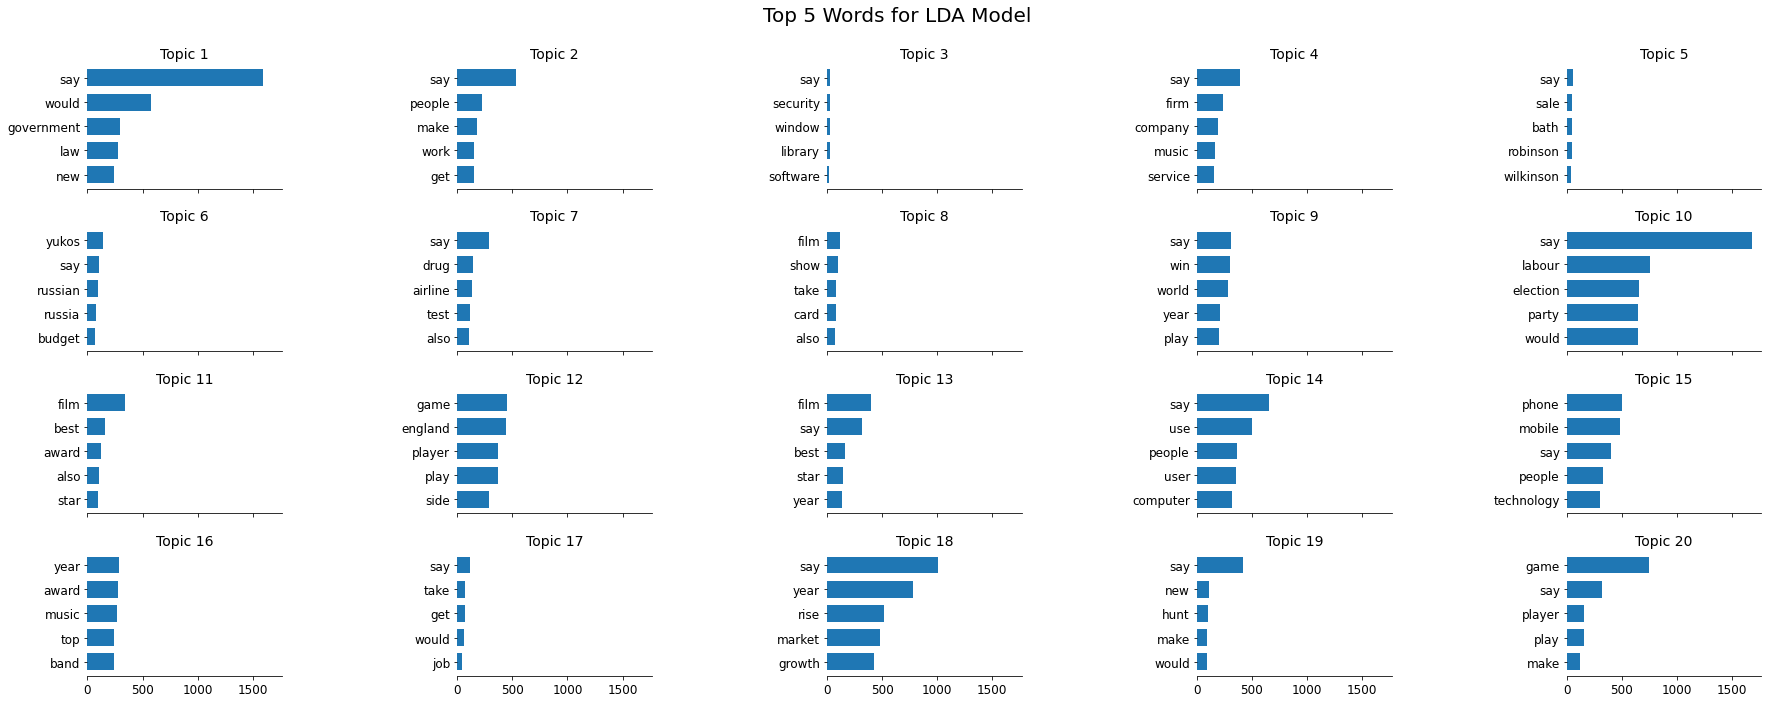

Saving LDA Visualization:
File saved.



Pickling model for future use (LDA model, vectorizer, document term matrix, parameters dictionary)

Files pickled


In [13]:
vectorizer, dtm, lda_model = pipeline(texts, 20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Parameters are: 
max_df:  0.5 
min_df:  10 
ngram_range: (2, 3) 
vec_type:  tfidf 
n_top_words:  5 

Using TfidfVectorizer

Number of topics:  20
Random state:  42

Log Likelihood (the higher the better):  -78964.52624794412
Perplexity (the lower the better):  25125.420303906154

Model Parameters:
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 42,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


Topic #0: security exchange commission, exchange commission, security exchange, market share, say expect
Topic #1: film festival, european indoor, five live, indoor championship, european indoor championship
Topic #2: lib dems, liberal democrat, lib dem, charles kennedy, tory leader
Topic #3: home secretary, home office, david b

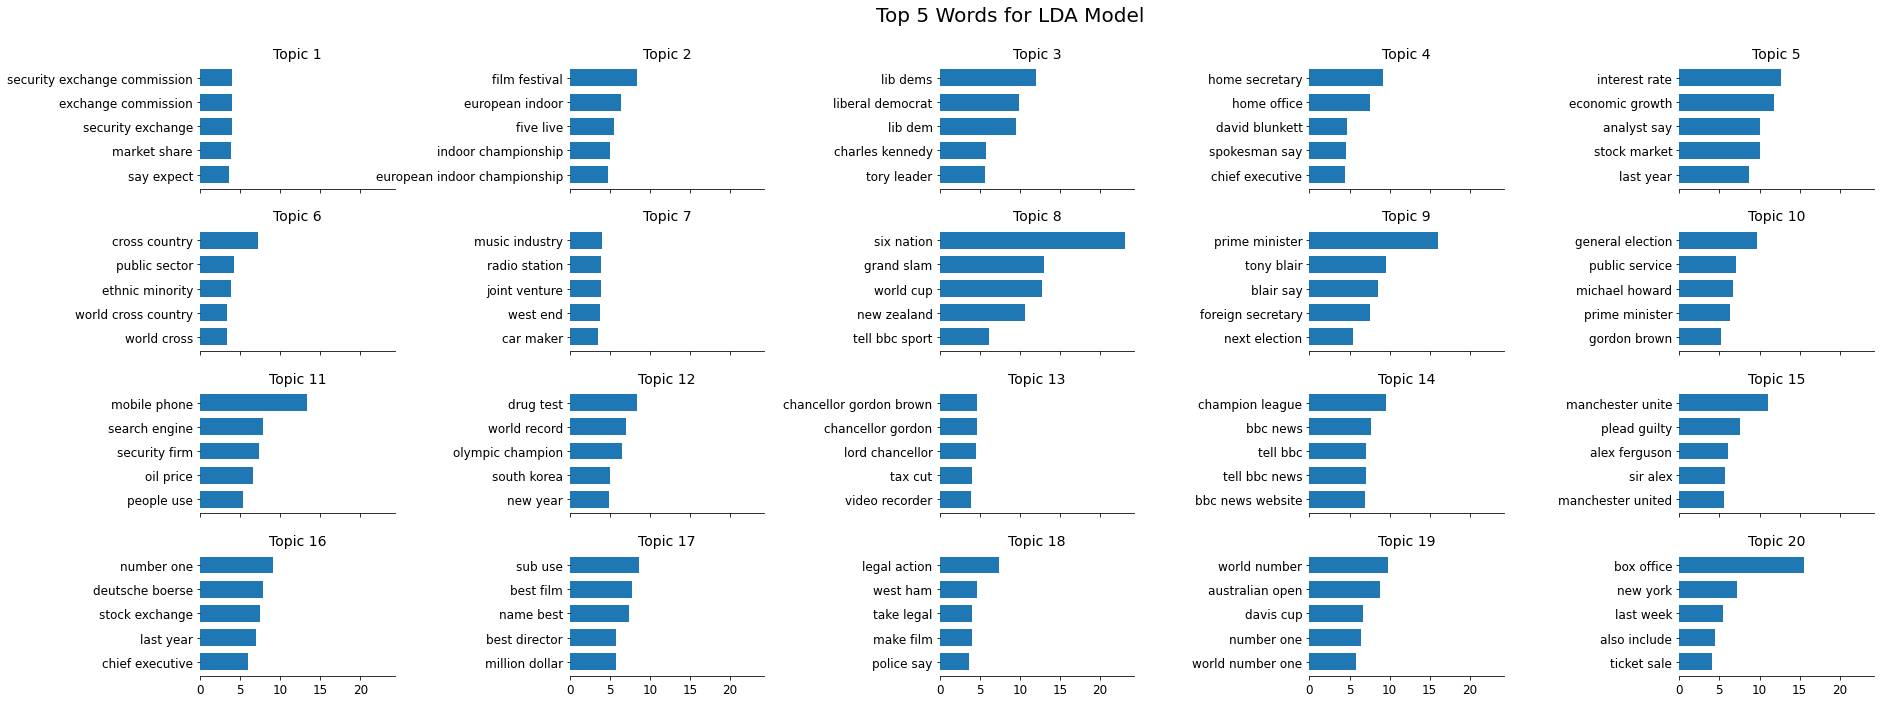

Saving LDA Visualization:
File saved.



Pickling model for future use (LDA model, vectorizer, document term matrix, parameters dictionary)

Files pickled


In [15]:
max_df = .5
min_df = 10
ngram_range = (2,3)
random_state = 42
vec_type = 'tfidf'
n_topics = 20

vectorizer, dtm, lda_model = pipeline(texts, n_topics, random_state, max_df, min_df, ngram_range, vec_type)

In [ ]:
pyLDAvis.sklearn.prepare(lda_model, dtm, vectorizer)

In [ ]:
def optimised_lda_model(texts):
    n_top_words = 5
    
    vectorizer = CountVectorizer(min_df=10,
                                 max_df=.5,
                                 ngram_range=(2,5))
    
    data_vectorized = vectorizer.fit_transform(texts)
    
    # Define Search Param
    search_params = {'n_components': [5, 10, 15, 20, 25],
                     'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LDA(max_iter=5, learning_method='online', learning_offset=50., random_state=42)

    # Init Grid Search Class
    grid_model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    grid_model.fit(data_vectorized)

    GridSearchCV(cv=None, 
                 error_score='raise',
                 estimator=LDA(batch_size=128, 
                               doc_topic_prior=None,
                               evaluate_every=-1,
                               learning_decay=0.7,
                               learning_method=None,
                               learning_offset=10.0, 
                               max_doc_update_iter=100, 
                               max_iter=10,
                               mean_change_tol=0.001, 
                               n_components=10, 
                               n_jobs=1, 
                               #n_topics=None, 
                               perp_tol=0.1, 
                               random_state=None,
                               topic_word_prior=None, 
                               total_samples=1000000.0, 
                               verbose=0
                              ),
                 n_jobs=1,
                 param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
                 pre_dispatch='2*n_jobs',
                 refit=True,
                 return_train_score='warn',
                 scoring=None,
                 verbose=0)
    
    # Best Model
    best_lda_model = grid_model.best_estimator_

    log_likelihood = grid_model.best_score_
    perplexity = best_lda_model.perplexity(data_vectorized)
    model_params = grid_model.best_params_
    
    # Model Parameters
    print("Best Model's Params: ", grid_model.best_params_)

    # Log Likelihood Score
    print("Best Log Likelihood Score: ", grid_model.best_score_)

    # Perplexity
    print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))
    
    parameters_dict = {
        'vec_type': 'cv',
        'random_state': 42,
        'log_likelihood': log_likelihood,
        'perplexity': perplexity,
        'model_params': model_params,
    }
    
    create_LDA_dataframe(df, best_lda_model, data_vectorized, vectorizer)
    
    print('\n')
    print_top_words(best_lda_model, vectorizer.get_feature_names(), n_top_words)
    print('\n')
    plot_top_words(best_lda_model, vectorizer, data_vectorized, n_top_words, 
                   title="Top {} Words for LDA Model".format(n_top_words))
       
    print('Pickling model for future use (LDA model, vectorizer, document term matrix, parameters dictionary)\n')
    
    pickle.dump(vectorizer, 
                open('./models/optimal_vec_{}topics_{}.pickle'.format(int(best_lda_model.n_components), current_time()), 'wb'))
    pickle.dump(data_vectorized, 
                open('./models/optimal_dtm_{}topics_{}.pickle'.format(int(best_lda_model.n_components), current_time()), 'wb'))
    pickle.dump(best_lda_model, 
                open('./models/optimal_fit_model_{}topics_{}.pickle'.format(int(best_lda_model.n_components), current_time()), 'wb'))
    pickle.dump(parameters_dict, 
                open('./models/optimal_parameters_{}topics_{}.pickle'.format(int(best_lda_model.n_components), current_time()), 'wb'))
    print('Files pickled')
    
    return vectorizer, data_vectorized, best_lda_model

In [ ]:
def create_LDA_dataframe(df, model, data_vectorized, vectorizer):
    df.title.values.tolist()
    # Create Document — Topic Matrix
    lda_output = model.transform(data_vectorized)

    # column names
    topicnames = ['Topic' + str(i) for i in range(model.n_components)]

    # index names
    docnames = ['Doc' + str(i) for i in range(len(df))]

    #################################################################################
    # Make the pandas dataframe that has document number as index and topic scores as values
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic
    df_document_topic['title'] = df.title.values
    
    # View
    display(df_document_topic)
    ##################################################################################
    ##################################################################################
    ##################################################################################
    # Create topic keywords dataframe with topics as Rows and top 10 words as Values
    keywords = np.array(vectorizer.get_feature_names())

    topic_keywords = []
    for weights in model.components_:
        word_locs = (-weights).argsort()[:10]
        topic_keywords.append(keywords.take(word_locs))

    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['word_'+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['topic_'+str(i) for i in range(df_topic_keywords.shape[0])]
    
    topics = ['politics_1',
             'sports',
             'politics_2',
             'entertainment',
             'technology'
             ]
    df_topic_keywords["topics"]=topics
    df_topic_keywords
        
    # View
    display(df_topic_keywords)
    ####################################################################################
    
    print('Saving df_document_topic and df_topic_keywords dataframes\n')
    
    pickle.dump(df_document_topic, open(model_dir / 'df_document_topic_{}.pickle'.format(current_time()), 'wb'))
    pickle.dump(df_topic_keywords, open(model_dir / 'df_topic_keywords_{}.pickle'.format(current_time()), 'wb'))
    
    return

In [ ]:
opt_vectorizer, opt_data_vectorized, best_lda_model = optimised_lda_model(texts)

In [ ]:
pyLDAvis.sklearn.prepare(best_lda_model, opt_data_vectorized, opt_vectorizer)